# 1/4 Cluster Evolution using tensor contraction.
### 2D EA with external Field

In [48]:
import torch
import numpy as np
import numba as nb
from scipy.linalg import sqrtm

In [49]:
import math
import time
from tqdm.auto import trange

In [50]:
from collections import defaultdict

In [51]:
import copy

In [52]:
import pickle

In [6]:
import seaborn as sns

In [7]:
import matplotlib.pyplot as plt

---------------------------------
### 1/4 Cluster

In [8]:
def j_matrix_init():
    global j_matrix
    #np.random.seed(1288688)
    j_matrix = np.zeros((dims[0], dims[1], 4), dtype=np.int8)
    for i in range(dims[0]):
        for j in range(dims[1]):
            j_matrix[i][j] = (-1) ** np.random.binomial(1, 1/2, 4)
    for i in range(dims[0]):
        for j in range(dims[1]):
            j_matrix[i][j][3] = j_matrix[(i-1)%dims[0]][j][1]
            j_matrix[i][j][0] = j_matrix[i][(j-1)%dims[1]][2]

In [9]:
def j_pos_one_matrix_init():
    global j_matrix
    j_matrix = np.ones((dims[0], dims[1], 4), dtype=np.float64)

In [10]:
def j_neg_one_matrix_init():
    global j_matrix
    j_matrix = -1 * np.ones((dims[0], dims[1], 4), dtype=np.float64)    

In [11]:
def j_matrix_frust_init():
    global j_matrix
    j_matrix = np.ones((dims[0], dims[1], 4), dtype=np.int8)
    for i in range(dims[0]):
        for j in range(dims[1]):
            if j % 2 != 0:
                j_matrix[i][j][1] = -1
                j_matrix[i][j][3] = -1
    for i in range(dims[0]):
        for j in range(dims[1]):
            j_matrix[i][j][3] = j_matrix[(i-1)%dims[0]][j][1]
            j_matrix[i][j][0] = j_matrix[i][(j-1)%dims[1]][2]

In [9]:
def B_tensor_prepare(j_vec):
    B_list = []
    for jj in j_vec:
        if jj == 1:
            B_list.append(B_pos)
        else:
            B_list.append(B_neg)
    return B_list

In [10]:
def bdy_vector_prepare(grid, id_loc, pos_index):
    """
    Args:
        grid: (np.array)
        id_loc: (tuple)
        pos_index: (int) 
        
    Returns:
        bdy_vector: (np.array)
    """
    id_row, id_col = id_loc
    if grid[id_row][id_col] == 1:
        if j_matrix[id_row][id_col][pos_index] == 1:
            bdy_vector = spin_pos_up
        else:
            bdy_vector = spin_neg_up
    else:
        if j_matrix[id_row][id_col][pos_index] == 1:
            bdy_vector = spin_pos_down
        else:
            bdy_vector = spin_neg_down
    return bdy_vector

In [11]:
def parameters_init(dims_init, beta_init, h_init):
    global grid_1, grid_2, dims, beta, h
    #np.random.seed(314)
    #np.random.seed(181)
    #np.random.seed(0)
    dims = (nb.int64(dims_init[0]), nb.int64(dims_init[1]))
    beta, h = nb.float64(beta_init), nb.float64(h_init)
    grid_1 = np.reshape(np.random.choice([nb.int8(-1), nb.int8(1)], 
                                         size=dims_init[0]*dims_init[1]), dims_init)
    grid_2 = np.reshape(np.random.choice([nb.int8(-1), nb.int8(1)], 
                                         size=dims_init[0]*dims_init[1]), dims_init)

In [12]:
global grid_1, grid_2, dims, beta, j_matrix, h

In [13]:
#dims_init = (4, 4)
#dims_init = (8, 8)
#dims_init = (16, 16)
dims_init = (32, 32)
#dims_init = (64, 64)
#beta_init, h_init = np.log(1 + np.sqrt(2)) / 2, 1
beta_init, h_init = 1, 0
parameters_init(dims_init, beta_init, h_init)

In [14]:
#j_matrix_frust_init()
j_matrix_init()
#j_neg_one_matrix_init()
#j_pos_one_matrix_init()

In [48]:
with open(f'../data_2d_ea/ea_size_{dims[0]}_j_matrix.pkl', 'wb') as file:
    pickle.dump(j_matrix, file)

In [49]:
with open(f'../data_2d_ea/ea_size_{dims[0]}_j_matrix.pkl', 'rb') as file:
    j_matrix = pickle.load(file)

In [15]:
my_device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [16]:
def node_tensor_create(my_device=my_device):
    I_1, I_2, I_3, I_4, I_up, I_down = copy_tensor_create(my_device)
    B_pos = torch.tensor(sqrtm(np.array([[np.exp(beta),np.exp(-beta)], 
                                         [np.exp(-beta),np.exp(beta)]])), 
                         dtype=torch.complex128, device=my_device)
    B_neg = torch.tensor(sqrtm(np.array([[np.exp(-beta),np.exp(beta)], 
                                         [np.exp(beta),np.exp(-beta)]])), 
                         dtype=torch.complex128, device=my_device)
    spin_up = torch.tensor([1, 0], dtype=torch.complex128, device=my_device)
    spin_down = torch.tensor([0, 1], dtype=torch.complex128, device=my_device)
    spin_pos_up = torch.einsum("i, ij -> j", [spin_up, B_pos])
    spin_pos_down = torch.einsum("i, ij -> j", [spin_down, B_pos])
    spin_neg_up = torch.einsum("i, ij -> j", [spin_up, B_neg])
    spin_neg_down = torch.einsum("i, ij -> j", [spin_down, B_neg])
    return B_pos, B_neg, spin_pos_up, spin_pos_down, spin_neg_up, spin_neg_down

In [17]:
def copy_tensor_create(my_device=my_device):
    I_2_array = np.zeros((2, 2))
    I_3_array = np.zeros((2, 2, 2))
    I_4_array = np.zeros((2, 2, 2, 2))
    I_up_array = np.zeros((2, 2, 2, 2))
    I_down_array = np.zeros((2, 2, 2, 2))
    for i in range(2):
        if i == 0:
            I_2_array[i, i] = np.exp(beta * h)
            I_3_array[i, i, i] = np.exp(beta * h)
            I_4_array[i, i, i, i] = np.exp(beta * h)
        else:
            I_2_array[i, i] = np.exp(-beta * h)
            I_3_array[i, i, i] = np.exp(-beta * h)
            I_4_array[i, i, i, i] = np.exp(-beta * h)
    I_up_array[0][0][0][0] = np.exp(beta * h)
    I_down_array[1][1][1][1] = np.exp(-beta * h)
    I_1 = torch.tensor([np.exp(beta * h), np.exp(-beta * h)], dtype=torch.complex128, device=my_device)
    I_2 = torch.tensor(I_2_array, dtype=torch.complex128, device=my_device)
    I_3 = torch.tensor(I_3_array, dtype=torch.complex128, device=my_device)
    I_4 = torch.tensor(I_4_array, dtype=torch.complex128, device=my_device)
    I_up = torch.tensor(I_up_array, dtype=torch.complex128, device=my_device)
    I_down = torch.tensor(I_down_array, dtype=torch.complex128, device=my_device)
    return I_1, I_2, I_3, I_4, I_up, I_down

In [18]:
def row_tensor_mpo_create(row_id):
    row_tensor_mpo = []
    for col_id in range(dims[1]):
        B_list = []
        j_vec = j_matrix[row_id][col_id]
        for jj in j_vec:
            if jj == 1:
                B_list.append(B_pos)
            else:
                B_list.append(B_neg)
        B_list.append(I_4)
        A_4_i = torch.einsum("ij, kl, mn, pq, jlnq -> ikmp", B_list)
        A_4_i = A_4_i / A_4_i.norm()
        row_tensor_mpo.append(A_4_i)
    return row_tensor_mpo

In [19]:
def tensor_mpo_create():
    tensor_mpo = []
    for row_id in range(dims[0]):
        row_tensor_mpo_i = row_tensor_mpo_create(row_id)
        tensor_mpo.append(row_tensor_mpo_i)
    return tensor_mpo

In [20]:
global I_1, I_2, I_3, I_4, I_up, I_down

In [21]:
global B_pos, B_neg, spin_pos_up, spin_pos_down, spin_neg_up, spin_neg_down

In [22]:
global tensor_mpo

In [23]:
def tensors_init(my_device=my_device):
    global I_1, I_2, I_3, I_4, I_up, I_down
    global B_pos, B_neg, spin_pos_up, spin_pos_down, spin_neg_up, spin_neg_down
    global tensor_mpo
    I_1, I_2, I_3, I_4, I_up, I_down = copy_tensor_create(my_device)
    B_pos, B_neg, spin_pos_up, spin_pos_down, spin_neg_up, spin_neg_down = node_tensor_create(my_device)
    tensor_mpo = tensor_mpo_create()

In [24]:
tensors_init()

In [25]:
def row_tensor_create(grid, id_left_bdy, id_right_bdy, id_up_bdy, id_down_bdy, my_device=my_device):
    num_cols = id_right_bdy - id_left_bdy + 1
    left_bdy_list, right_bdy_list = [], []
    up_bdy_list, down_bdy_list = [], []
    for i in range(id_up_bdy, id_down_bdy+1):
        tuple_left_bdy = (i, (id_left_bdy-1)%dims[1])
        tuple_right_bdy = (i, (id_right_bdy+1)%dims[1])
        left_bdy_vector = bdy_vector_prepare(grid, tuple_left_bdy, 2)
        left_bdy_list.append(left_bdy_vector)
        right_bdy_vector = bdy_vector_prepare(grid, tuple_right_bdy, 0)
        right_bdy_list.append(right_bdy_vector)
    for jj in range(id_left_bdy, id_right_bdy+1):
        tuple_up_bdy = ((id_up_bdy-1)%dims[0], jj)
        tuple_down_bdy = ((id_down_bdy+1)%dims[0], jj)
        up_bdy_vector = bdy_vector_prepare(grid, tuple_up_bdy, 1)
        down_bdy_vector = bdy_vector_prepare(grid, tuple_down_bdy, 3)
        up_bdy_list.append(up_bdy_vector)
        down_bdy_list.append(down_bdy_vector)
    ### contracting boundary vector with mpo to get the col mps
    row_up_mps, row_down_mps = [], []
    A_4_up, A_4_down = tensor_mpo[id_up_bdy][id_left_bdy], tensor_mpo[id_down_bdy][id_left_bdy]
    start_up_tensor = torch.einsum("ijkl, l, mi -> mjk", [A_4_up, up_bdy_list[0], torch.unsqueeze(left_bdy_list[0], 0)])
    start_up_tensor = start_up_tensor / start_up_tensor.norm()
    start_down_tensor = torch.einsum("ijkl, j, mi -> mkl", [A_4_down, down_bdy_list[0], torch.unsqueeze(left_bdy_list[-1], 0)])
    start_down_tensor = start_down_tensor / start_down_tensor.norm()
    row_up_mps.append(start_up_tensor)
    row_down_mps.append(start_down_tensor)
    for i in range(id_left_bdy+1, id_right_bdy):
        A_4_up = tensor_mpo[id_up_bdy][i]
        A_4_down = tensor_mpo[id_down_bdy][i]
        tensor_up_mps = torch.einsum("ijkl, l -> ijk", [A_4_up, up_bdy_list[i-id_left_bdy]])
        tensor_up_mps = tensor_up_mps / tensor_up_mps.norm()
        tensor_down_mps = torch.einsum("ijkl, j -> ikl", [A_4_down, down_bdy_list[i-id_left_bdy]])
        tensor_down_mps = tensor_down_mps / tensor_down_mps.norm()
        row_up_mps.append(tensor_up_mps)
        row_down_mps.append(tensor_down_mps) 
    A_4_up, A_4_down = tensor_mpo[id_up_bdy][id_right_bdy], tensor_mpo[id_down_bdy][id_right_bdy]
    end_up_tensor = torch.einsum("ijkl, l, km -> ijm", [A_4_up, up_bdy_list[-1], torch.unsqueeze(right_bdy_list[0], 1)])
    end_up_tensor = end_up_tensor / end_up_tensor.norm()
    end_down_tensor = torch.einsum("ijkl, j, km -> iml", [A_4_down, down_bdy_list[-1], torch.unsqueeze(right_bdy_list[-1], 1)])
    end_down_tensor = end_down_tensor / end_down_tensor.norm()
    row_up_mps.append(end_up_tensor)
    row_down_mps.append(end_down_tensor)
    return row_up_mps, row_down_mps

In [26]:
def row_down_mps_create(grid, id_bdy, id_row):
    id_left_bdy, id_right_bdy, id_up_bdy, id_down_bdy = id_bdy 
    num_rows = id_right_bdy - id_left_bdy + 1
    mpo_i = tensor_mpo[id_row]
    down_bdy_list = []
    for jj in range(id_left_bdy, id_right_bdy+1):
        tuple_down_bdy = ((id_row+1)%dims[0], jj)
        down_bdy_vector = bdy_vector_prepare(grid, tuple_down_bdy, 3)
        down_bdy_list.append(down_bdy_vector)
    tuple_left_bdy = (id_row, (id_left_bdy-1)%dims[1])
    left_bdy_vector = bdy_vector_prepare(grid, tuple_left_bdy, 2)
    tuple_right_bdy = (id_row, (id_right_bdy+1)%dims[1])
    right_bdy_vector = bdy_vector_prepare(grid, tuple_right_bdy, 0)  
    row_down_mps = []
    start_down_tensor = torch.einsum("ijkl, j, mi -> mkl", [mpo_i[id_left_bdy], down_bdy_list[0], torch.unsqueeze(left_bdy_vector, 0)])
    start_down_tensor = start_down_tensor / start_down_tensor.norm()
    row_down_mps.append(start_down_tensor)
    for i in range(1, num_rows-1):
        tensor_down_mps = torch.einsum("ijkl, j -> ikl", [mpo_i[id_left_bdy+i], down_bdy_list[i]])
        tensor_down_mps = tensor_down_mps / tensor_down_mps.norm()
        row_down_mps.append(tensor_down_mps)                           
    end_down_tensor = torch.einsum("ijkl, j, km -> iml", [mpo_i[id_right_bdy], down_bdy_list[-1], torch.unsqueeze(right_bdy_vector, 1)])
    end_down_tensor = end_down_tensor / end_down_tensor.norm()
    row_down_mps.append(end_down_tensor)
    return row_down_mps

In [27]:
def eat(mps, mpo):
    """
    This function comes from Prof. Pan Zhang's github.
    https://github.com/QuantumBFS/SSSS/blob/master/2_tensor_network/tensor_contraction_simple.ipynb
    """
    return [torch.einsum("ijk, abcj-> iabkc", mps[i], mpo[i]).contiguous().view(mps[i].shape[0] * mpo[i].shape[0], 2, -1) 
            for i in range(len(mps))]     

In [28]:
def eat_with_norm(mps, mpo):
    mps_list = []
    for i in range(len(mps)):
        mps_i = torch.einsum("ijk, abcj-> iabkc", mps[i], mpo[i]).contiguous().view(mps[i].shape[0] * mpo[i].shape[0], 2, -1)
        mps_i = mps_i / mps_i.norm()
        mps_list.append(mps_i)
    return mps_list

In [29]:
def compress(mps, chi):
    """
    This function comes from Prof. Pan Zhang's github. 
    https://github.com/QuantumBFS/SSSS/blob/master/2_tensor_network/tensor_contraction_simple.ipynb
    Note: This function is extended to complex field.
    """
    residual = 0
    for i in range(len(mps)-1): # From left to right, sweep once doing qr decompositions
        Q, R = torch.qr(mps[i].contiguous().view(mps[i].shape[0]*2, -1))
        mps[i] = Q.contiguous().view(mps[i].shape[0], 2, -1)
        mps[i+1] = torch.einsum("ij,jab->iab", [R, mps[i+1]])
    for i in range(len(mps) - 1, 0, -1): # From right to left, sweep onece using svd on the tensor merged from two consecutive tensors.
        [U,s,V]=torch.svd(torch.einsum("ijk, kab->ijab", mps[i-1], mps[i]).view(mps[i-1].shape[0] * 2, mps[i].shape[2]*2))
        s = s.to(dtype=torch.complex128)
        #print(s.shape)
        #print(torch.sum(torch.abs(s[:chi])))
        #print(torch.sum(torch.abs(s)))
        err = 1 - torch.sum(torch.abs(s[:chi])) / torch.sum(torch.abs(s))
        mps[i] = torch.conj(V[:, :chi]).t().contiguous().view(-1, 2, mps[i].shape[2])
        mps[i-1] = (U[:, :chi]@torch.diag(s[:chi])).contiguous().view(mps[i-1].shape[0],2,-1)
        tnorm=mps[i-1].norm()
        mps[i-1] /= tnorm
        #print(tnorm)
        residual += math.log(tnorm)
    return residual, mps, err

In [30]:
def compress_without_trunc(mps):
    """
    This function comes from Prof. Pan Zhang's github. 
    https://github.com/QuantumBFS/SSSS/blob/master/2_tensor_network/tensor_contraction_simple.ipynb
    Note: This function is extended to complex field.
    """
    residual = 0
    for i in range(len(mps)-1): # From left to right, sweep once doing qr decompositions
        Q, R = torch.qr(mps[i].contiguous().view(mps[i].shape[0]*2, -1))
        mps[i] = Q.contiguous().view(mps[i].shape[0], 2, -1)
        mps[i+1] = torch.einsum("ij,jab->iab", [R, mps[i+1]])
    for i in range(len(mps) - 1, 0, -1): # From right to left, sweep onece using svd on the tensor merged from two consecutive tensors.
        [U, s, V]=torch.svd(torch.einsum("ijk, kab->ijab", mps[i-1], mps[i]).view(mps[i-1].shape[0] * 2, mps[i].shape[2]*2))
        s = s.to(dtype=torch.complex128)
        mps[i] = torch.conj(V).t().contiguous().view(-1, 2, mps[i].shape[2])
        mps[i-1] = (U@torch.diag(s)).contiguous().view(mps[i-1].shape[0], 2, -1)
        tnorm = mps[i-1].norm()
        mps[i-1] /= tnorm
        residual += math.log(tnorm)
    return residual, mps    

In [53]:
def contract_up_to_down(grid, id_bdy, bond_dims=20):
    id_left_bdy, id_right_bdy, id_up_bdy, id_down_bdy = id_bdy
    row_up_mps, row_down_mps = row_tensor_create(grid, id_left_bdy, id_right_bdy, id_up_bdy, id_down_bdy)
    stack_mps = []
    num_rows = id_down_bdy - id_up_bdy + 1
    stack_mps.append(row_up_mps)
    mps_orig = row_up_mps
    row_tensor_mpo_bdy = tensor_mpo[id_up_bdy+1][id_left_bdy:id_right_bdy+1]
    for i in range(num_rows-2):
        tuple_left_bdy = (id_up_bdy+i+1, (id_left_bdy-1)%dims[1])
        tuple_right_bdy = (id_up_bdy+i+1, (id_right_bdy+1)%dims[1])
        left_bdy_vector = bdy_vector_prepare(grid, tuple_left_bdy, 2)
        right_bdy_vector = bdy_vector_prepare(grid, tuple_right_bdy, 0)
        row_tensor_mpo_bdy[0] = torch.einsum("ijkl, mi -> mjkl", [row_tensor_mpo_bdy[0], torch.unsqueeze(left_bdy_vector, 0)])
        row_tensor_mpo_bdy[-1] = torch.einsum("ijkl, km -> ijml", [row_tensor_mpo_bdy[-1], torch.unsqueeze(right_bdy_vector, 1)])
        #mps_orig = eat(mps_orig, row_tensor_mpo_bdy)
        mps_orig = eat_with_norm(mps_orig, row_tensor_mpo_bdy)
        #_, mps_orig, err = compress(mps_orig, bond_dims)
        _, mps_orig = compress_without_trunc(mps_orig)
        stack_mps.append(mps_orig)
        row_tensor_mpo_bdy = tensor_mpo[id_up_bdy+2+i][id_left_bdy:id_right_bdy+1]
    return stack_mps, row_down_mps

In [54]:
def row_sampling(grid, id_row, id_bdy, mps_base, row_down_mps, my_device=my_device):
    id_left_bdy, id_right_bdy, id_up_bdy, id_down_bdy = id_bdy
    #mps_base = stack_mps.pop()
    stack_contract = []
    tensor_start = torch.einsum("ijk, lmj -> ilkm", [mps_base[-1], row_down_mps[-1]])
    tensor_start = tensor_start / tensor_start.norm()
    tensor_start = tensor_start.squeeze()
    ### tensor_start shape il
    stack_contract.append(tensor_start)
    for i in range(len(mps_base)-2, 0, -1):
        tensor_i = torch.einsum("ijk, lmj -> ilkm", [mps_base[i], row_down_mps[i]])
        tensor_i = tensor_i / tensor_i.norm()
        tensor_start = torch.einsum("ijkl, kl -> ij", [tensor_i, tensor_start])
        tensor_start = tensor_start / tensor_start.norm()
        stack_contract.append(tensor_start)
    ### Samping the head of the row
    id_tensor = 0
    tuple_left_bdy = (id_row, (id_left_bdy-1)%dims[1])
    tuple_down_bdy = ((id_row+1)%dims[0], id_left_bdy)
    left_bdy_vector = bdy_vector_prepare(grid, tuple_left_bdy, 2)
    down_bdy_vector = bdy_vector_prepare(grid, tuple_down_bdy, 3)
    j_vector = j_matrix[id_row][id_left_bdy]
    B_left, B_down, B_right, B_up = B_tensor_prepare(j_vector)
    tensor_right = stack_contract.pop()
    tensor_right = torch.einsum("ij, mj -> im ", [tensor_right, B_right])
    tensor_down = torch.einsum("ij, j -> i", [B_down, down_bdy_vector])
    tensor_left = torch.einsum("ij, j -> i", [B_left, left_bdy_vector])
    tensor_up = mps_base[id_tensor]
    tensor_up = torch.einsum("ijk, jl -> ilk", [tensor_up, B_up])
    tensor_up = tensor_up.squeeze()
    ### tensor_up shape lk
    z_four_edge = torch.einsum("ij, jl, k, m -> ilkm", [tensor_up, tensor_right, tensor_down, tensor_left])
    z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
    z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
    z = z_up + z_down
    prob_up_real = z_up.real / z.real
    #print(z)
    #print(prob_up_real)
    prob_rand = np.random.random()
    if prob_rand < prob_up_real:
        grid[id_row][id_left_bdy] = 1
        spin_vector = torch.tensor([1, 0], dtype=torch.complex128, device=my_device)
    else:
        grid[id_row][id_left_bdy] = -1
        spin_vector = torch.tensor([0, 1], dtype=torch.complex128, device=my_device)
    tensor_up = torch.einsum("ij, i -> j", [tensor_up, spin_vector])
    tensor_up = tensor_up / tensor_up.norm()
    id_tensor += 1
    ### Sampling the body of the row
    for i in range(id_left_bdy+1, id_right_bdy):
        j_vector = j_matrix[id_row][i]
        tuple_left_bdy = (id_row, (i-1)%dims[1])
        tuple_down_bdy = ((id_row+1)%dims[0], i)
        left_bdy_vector = bdy_vector_prepare(grid, tuple_left_bdy, 2)
        down_bdy_vector = bdy_vector_prepare(grid, tuple_down_bdy, 3)
        B_left, B_down, B_right, B_up = B_tensor_prepare(j_vector)
        tensor_right = stack_contract.pop()
        tensor_right = torch.einsum("ij, mj -> im", [tensor_right, B_right])
        tensor_left = torch.einsum("ij, j -> i", [B_left, left_bdy_vector])
        tensor_up = torch.einsum("i, ijk, jl -> lk", [tensor_up, mps_base[id_tensor], B_up])
        tensor_down = torch.einsum("ij, j -> i", [B_down, down_bdy_vector])
        z_four_edge = torch.einsum("ij, jk, m, n -> ikmn", [tensor_up, tensor_right, tensor_down, tensor_left])
        z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
        z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
        z = z_up + z_down
        prob_up_real = z_up.real / z.real
        #print(z)
        #print(prob_up_real)
        #print(z_up/z)
        prob_rand = np.random.random()
        if prob_rand < prob_up_real:
            grid[id_row][i] = 1
            spin_vector = torch.tensor([1, 0], dtype=torch.complex128, device=my_device)
        else:
            grid[id_row][i] = -1
            spin_vector = torch.tensor([0, 1], dtype=torch.complex128, device=my_device)
        tensor_up = torch.einsum("ij, i -> j", [tensor_up, spin_vector])
        tensor_up = tensor_up / tensor_up.norm()
        id_tensor += 1
    ### Sampling the end of the row
    j_vec = j_matrix[id_row][id_right_bdy]
    B_left, B_down, B_right, B_up = B_tensor_prepare(j_vec)
    tuple_left_bdy = (id_row, (id_right_bdy-1)%dims[1])
    tuple_down_bdy = ((id_row+1)%dims[0], id_right_bdy)
    tuple_right_bdy = (id_row, (id_right_bdy+1)%dims[1])
    left_bdy_vector = bdy_vector_prepare(grid, tuple_left_bdy, 2)
    down_bdy_vector = bdy_vector_prepare(grid, tuple_down_bdy, 3)
    right_bdy_vector = bdy_vector_prepare(grid, tuple_right_bdy, 0)
    tensor_right = torch.einsum("ij, j -> i", [B_right, right_bdy_vector])
    tensor_down = torch.einsum("ij, j -> i", [B_down, down_bdy_vector])
    tensor_left = torch.einsum("ij, j -> i", [B_left, left_bdy_vector])
    tensor_up = torch.einsum("j, jik, il -> lk", [tensor_up, mps_base[id_tensor], B_up])
    tensor_up = tensor_up.squeeze()
    z_four_edge = torch.einsum("i, j, k, l -> ijkl", [tensor_up, tensor_right, tensor_down, tensor_left])
    z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
    z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
    z = z_up + z_down
    prob_up_real = z_up.real / z.real
    #print(z)
    #print(prob_up_real)
    #print(z_up/z)
    prob_rand = np.random.random()
    if prob_rand < prob_up_real:
        grid[id_row][id_right_bdy] = 1
        spin_vector = torch.tensor([1, 0], dtype=torch.complex128, device=my_device)
    else:
        grid[id_row][id_right_bdy] = -1
        spin_vector = torch.tensor([0, 1], dtype=torch.complex128, device=my_device)
    return grid

In [55]:
def mps_contract(mps_up, mps_down):
    tensor_start = torch.einsum("ijk, lmj -> ilkm", [mps_up[0], mps_down[0]])
    tensor_start = torch.squeeze(tensor_start)
    for i in range(1, len(mps_up)-1):
        tensor_i = torch.einsum("ijk, lmj -> ilkm", [mps_up[i], mps_down[i]])
        tensor_start = torch.einsum("ij, ijkl -> kl", [tensor_start, tensor_i])
    tensor_end = torch.einsum("iml, jkm -> ijlk", [mps_up[-1], mps_down[-1]])
    tensor_end = torch.squeeze(tensor_end)
    z = torch.einsum("ij, ij -> ", [tensor_start, tensor_end])
    return z

In [56]:
def base_row_sampling(grid, id_bdy):
    id_left_bdy, id_right_bdy, id_up_bdy, id_down_bdy = id_bdy
    id_row = id_up_bdy
    base_row_mps = row_down_mps_create(grid, id_bdy, id_row)
    stack_contract, up_bdy_vector_list = [], []
    tuple_up_bdy = ((id_up_bdy-1)%dims[0], id_right_bdy)
    up_bdy_vector = bdy_vector_prepare(grid, tuple_up_bdy, 1)
    tensor_start = torch.einsum("ijk, k -> ij", [base_row_mps[-1], up_bdy_vector])
    tensor_start = tensor_start.squeeze()
    ### tensor_start shape i
    id_tensor = -2
    stack_contract.append(tensor_start)
    up_bdy_vector_list.append(up_bdy_vector)
    for i in range(id_right_bdy-1, id_left_bdy, -1):
        tuple_up_bdy = ((id_up_bdy-1)%dims[0], i)
        up_bdy_vector = bdy_vector_prepare(grid, tuple_up_bdy, 1)
        tensor_i = torch.einsum("ijk, k -> ij", [base_row_mps[id_tensor], up_bdy_vector])
        tensor_start = torch.einsum("ik, k -> i", [tensor_i, tensor_start])
        stack_contract.append(tensor_start)
        up_bdy_vector_list.append(up_bdy_vector)
        id_tensor -= 1
    ### Samping the head of the row
    id_tensor = 0
    j_vector = j_matrix[id_row][id_left_bdy]
    B_left, B_down, B_right, B_up = B_tensor_prepare(j_vector)
    tuple_left_bdy = (id_up_bdy, (id_left_bdy-1)%dims[1])
    tuple_down_bdy = ((id_up_bdy+1)%dims[0], id_left_bdy)
    tuple_up_bdy = ((id_up_bdy-1)%dims[0], id_left_bdy)
    left_bdy_vector = bdy_vector_prepare(grid, tuple_left_bdy, 2)
    down_bdy_vector = bdy_vector_prepare(grid, tuple_down_bdy, 3)
    up_bdy_vector = bdy_vector_prepare(grid, tuple_up_bdy, 1)
    tensor_right = stack_contract.pop()
    tensor_right = torch.einsum("i, mi -> m", [tensor_right, B_right])
    tensor_down = torch.einsum("ij, j -> i", [B_down, down_bdy_vector])
    tensor_left = torch.einsum("ij, j -> i", [B_left, left_bdy_vector])
    tensor_up = torch.einsum("ij, j -> i", [B_up, up_bdy_vector])
    z_four_edge = torch.einsum("i, j, k, l -> ijkl", [tensor_up, tensor_right, tensor_down, tensor_left])
    z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
    z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
    prob_up = z_up / (z_up + z_down)
    #print(prob_up)
    #print(z_up + z_down)
    prob_rand = np.random.random()
    if prob_rand < prob_up.real:
        grid[id_up_bdy][id_left_bdy] = 1
    else:
        grid[id_up_bdy][id_left_bdy] = -1
    ### Sampling the body of the row
    for i in range(id_left_bdy+1, id_right_bdy):
        j_vector = j_matrix[id_row][i]
        B_left, B_down, B_right, B_up = B_tensor_prepare(j_vector)
        up_bdy_vector = up_bdy_vector_list.pop()
        tuple_left_bdy = (id_up_bdy, i-1)
        left_bdy_vector = bdy_vector_prepare(grid, tuple_left_bdy, 2)
        tuple_down_bdy = ((id_up_bdy+1)%dims[0], i)
        down_bdy_vector = bdy_vector_prepare(grid, tuple_down_bdy, 3)
        tensor_right = stack_contract.pop()
        tensor_right = torch.einsum("i, mi -> m", [tensor_right, B_right])
        tensor_left = torch.einsum("ij, i -> j", [B_left, left_bdy_vector])
        tensor_up = torch.einsum("i, ij -> j", [up_bdy_vector, B_up])
        tensor_down = torch.einsum("ij, i -> j", [B_down, down_bdy_vector])
        z_four_edge = torch.einsum("i, j, m, n -> ijmn", [tensor_up, tensor_right, tensor_down, tensor_left])
        z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
        z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
        prob_up = z_up / (z_up + z_down)
        #print(prob_up)
        #print(z_up + z_down)
        prob_rand = np.random.random()
        if prob_rand < prob_up.real:
            grid[id_up_bdy][i] = 1
        else:
            grid[id_up_bdy][i] = -1
    ### Sampling the end of the row
    j_vector = j_matrix[id_row][id_right_bdy]
    B_left, B_down, B_right, B_up = B_tensor_prepare(j_vector)
    tuple_left_bdy = (id_up_bdy, id_right_bdy-1)
    left_bdy_vector = bdy_vector_prepare(grid, tuple_left_bdy, 2)
    up_bdy_vector = up_bdy_vector_list.pop()
    tuple_down_bdy = ((id_up_bdy+1)%dims[0], id_right_bdy)
    tuple_right_bdy = (id_up_bdy, (id_right_bdy+1)%dims[1])
    down_bdy_vector = bdy_vector_prepare(grid, tuple_down_bdy, 3)
    right_bdy_vector = bdy_vector_prepare(grid, tuple_right_bdy, 0)
    tensor_right = torch.einsum("j, ij -> i", [right_bdy_vector, B_right])
    tensor_down = torch.einsum("ij, j -> i", [B_down, down_bdy_vector])
    tensor_left = torch.einsum("ij, j -> i", [B_left, left_bdy_vector])
    tensor_up = torch.einsum("j, ij -> i", [up_bdy_vector, B_up])
    z_four_edge = torch.einsum("i, j, k, l -> ijkl", [tensor_up, tensor_right, tensor_down, tensor_left])
    z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
    z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
    prob_up = z_up / (z_up + z_down)
    #print(prob_up)
    #print(z_up + z_down)
    prob_rand = np.random.random()
    if prob_rand < prob_up.real:
        grid[id_up_bdy][id_right_bdy] = 1
    else:
        grid[id_up_bdy][id_right_bdy] = -1
    return grid

In [57]:
types_neibor_get_triangle_func = nb.types.UniTuple(nb.types.UniTuple(nb.int8, 2), 4)(nb.types.UniTuple(nb.int8, 2))
@nb.cfunc(types_neibor_get_triangle_func)
def neibor_get_square(id_grid):
    height, width = dims
    height_index, width_index = id_grid
    l_neibor = (height_index, (width_index - 1) % width)
    r_neibor = (height_index, (width_index + 1) % width)
    u_neibor = ((height_index - 1) % height, width_index)
    d_neibor = ((height_index + 1) % height, width_index)
    return (l_neibor, d_neibor, r_neibor, u_neibor)

In [58]:
def one_forth_sampling(grid, id_bdy, bond_dim=20):
    id_left_bdy, id_right_bdy, id_up_bdy, id_down_bdy = id_bdy
    stack_mps, row_down_mps = contract_up_to_down(grid, id_bdy, bond_dim)
    mps_base = stack_mps.pop()
    grid = row_sampling(grid, id_down_bdy, id_bdy, mps_base, row_down_mps)
    for i in range(id_down_bdy-1, id_up_bdy, -1):
        mps_base = stack_mps.pop()
        row_down_mps_i = row_down_mps_create(grid, id_bdy, i)
        grid = row_sampling(grid, i, id_bdy, mps_base, row_down_mps_i)
    grid = base_row_sampling(grid, id_bdy)
    return grid

In [59]:
def block_sampling_one_step(grid):
    num_rows, num_cols = dims[0], dims[1]
    row_bdy_1, row_bdy_2, row_bdy_3 = 0, num_rows // 2 - 1, num_rows - 1
    col_bdy_1, col_bdy_2, col_bdy_3 = 0, num_cols // 2 - 1, num_cols - 1
    # ul, ur
    # dl, dr
    id_bdy_dl = (col_bdy_1, col_bdy_2, row_bdy_1, row_bdy_2)
    id_bdy_dr = (col_bdy_2+1, col_bdy_3, row_bdy_1, row_bdy_2)
    id_bdy_ul = (col_bdy_1, col_bdy_2, row_bdy_2+1, row_bdy_3)
    id_bdy_ur = (col_bdy_2+1, col_bdy_3, row_bdy_2+1, row_bdy_3)
    # sampling all the four pieces of the block
    grid = one_forth_sampling(grid, id_bdy_dl)
    grid = one_forth_sampling(grid, id_bdy_dr)
    grid = one_forth_sampling(grid, id_bdy_ul)
    grid = one_forth_sampling(grid, id_bdy_ur)
    return grid

In [60]:
def block_sampling_one_step_arbitrary(grid, bond_dim):
    num_rows, num_cols = dims[0], dims[1]
    row_bdy_1, row_bdy_2 = (0, num_rows // 4 - 1), (num_rows // 4, num_rows // 2 - 1)
    row_bdy_3, row_bdy_4 = (num_rows // 2, num_rows // 4 * 3 - 1), (num_rows // 4 * 3, num_rows - 1)
    col_bdy_1, col_bdy_2 = (0, num_cols // 4 - 1), (num_cols // 4, num_cols // 2 - 1)
    col_bdy_3, col_bdy_4 = (num_cols // 2, num_cols // 4 * 3 - 1), (num_cols // 4 * 3, num_cols - 1)  
    row_list = [row_bdy_1, row_bdy_2, row_bdy_3, row_bdy_4]
    col_list = [col_bdy_1, col_bdy_2, col_bdy_3, col_bdy_4]
    for row in row_list:
        for col in col_list:
            id_bdy_i = row + col
            grid = one_forth_sampling(grid, id_bdy_i, bond_dim)
    return grid

In [61]:
@nb.njit(nb.float32(nb.int8[:, :]))
def energy_compute_grids(grids):
    energy_total = 0
    for ii in range(dims[0]):
        for jj in range(dims[1]):
            id_neibors = neibor_get_square((nb.int8(ii), nb.int8(jj)))
            j_vector = j_matrix[ii][jj]
            for i, ij in enumerate(id_neibors):
                j = j_vector[i]
                energy_ij = -1/2 * j * grids[ij[0]][ij[1]] * grids[ii][jj]
                energy_total += energy_ij
            ### compute the energy of external field
            energy_total += -h * grids[ii][jj]
    energy_per_spin = energy_total / (dims[0] * dims[1])
    return energy_per_spin

In [62]:
@nb.njit(nb.float32(nb.int8[:, :]))
def magnet_grids(grids):
    m_mean = np.mean(grids)
    return m_mean

In [63]:
@nb.njit(nb.float64(nb.int8[:, :]))
def magnet_subgrids(grid):
    m_1, m_2 = 0, 0
    for i in range(dims[0]):
        for j in range(dims[1]):
            if (j + i) % 2 == 0:
                m_1 += grid[i][j]
            else:
                m_2 += grid[i][j]
    m_abs_per_spin = np.abs(m_1 - m_2) / (dims[0] * dims[1])
    return m_abs_per_spin

In [64]:
def grid_transform(grid):
    id_rand = np.random.randint(0, dims[0]*dims[1])
    id_row, id_col = id_rand // dims[0], id_rand % dims[0]
    grid_new = np.zeros((dims[0], dims[1]), dtype=np.int8)
    grid_new[:dims[0]-id_row, :dims[1]-id_col] = grid[id_row:, id_col:]
    grid_new[:dims[0]-id_row, dims[1]-id_col:] = grid[id_row:, :id_col]
    grid_new[dims[0]-id_row:, :dims[1]-id_col] = grid[:id_row, id_col:]
    grid_new[dims[0]-id_row:, dims[1]-id_col:] = grid[:id_row, :id_col]
    return grid_new

In [65]:
def one_forth_evv(grid_1, grid_2, num_steps, bond_dim=20):
    #grid_list = []
    magnet_list_1, magnet_list_2 = [], []
    energy_list_1, energy_list_2 = [], []
    q_list = []
    for i in trange(num_steps):
        energy_per_spin_1 = energy_compute_grids(grid_1)
        energy_per_spin_2 = energy_compute_grids(grid_2)
        magnet_per_spin_1 = magnet_grids(grid_1)
        magnet_per_spin_2 = magnet_grids(grid_2)
        magnet_list_1.append(magnet_per_spin_1)
        magnet_list_2.append(magnet_per_spin_2)
        energy_list_1.append(energy_per_spin_1)
        energy_list_2.append(energy_per_spin_2)
        #grid = block_sampling_one_step_arbitrary(grid, bond_dim)
        grid_1 = block_sampling_one_step(grid_1)
        grid_2 = block_sampling_one_step(grid_2)
        grid_1_vector = np.reshape(grid_1, -1)
        grid_2_vector = np.reshape(grid_2, -1)
        q_i = np.dot(grid_1_vector, grid_2_vector) / (dims[0] * dims[1])
        q_list.append(q_i)
        #grid = grid_transform(grid)
        #grid_list.append(grid.copy())
        #energy_list.append(energy_per_spin)
        #magnet_list.append(magnet_per_spin)
    #return grid, grid_list, energy_list, magnet_list
    energy_per_spin_1 = energy_compute_grids(grid_1)
    energy_per_spin_2 = energy_compute_grids(grid_2)
    magnet_per_spin_1 = magnet_grids(grid_1)
    magnet_per_spin_2 = magnet_grids(grid_2)
    magnet_list_1.append(magnet_per_spin_1)
    magnet_list_2.append(magnet_per_spin_2)
    energy_list_1.append(energy_per_spin_1)
    energy_list_2.append(energy_per_spin_2)
    return grid_1, grid_2, magnet_list_1, magnet_list_2, energy_list_1, energy_list_2, q_list

In [66]:
def spin_viz(grid, figsize=(10, 10), save=False, folder_name=None):
    fig = plt.figure(figsize=figsize)
    x, y = np.meshgrid(np.arange(0, dims[0]), np.arange(0, dims[1]))
    u = np.cos(grid*np.pi/2)
    v = np.sin(grid*np.pi/2)
    q = plt.quiver(x, y, u, v)
    plt.axis('off')
    plt.title('T={:.3f}, spins={}'.format(1/beta, dims), fontsize=20)
    if save and step is not None:
        plt.savefig(f'./{folder_name}/config_plot_step_{step}.pdf', dpi=100)
        plt.close(fig)

------------------
### Beta = 5, Size = 4

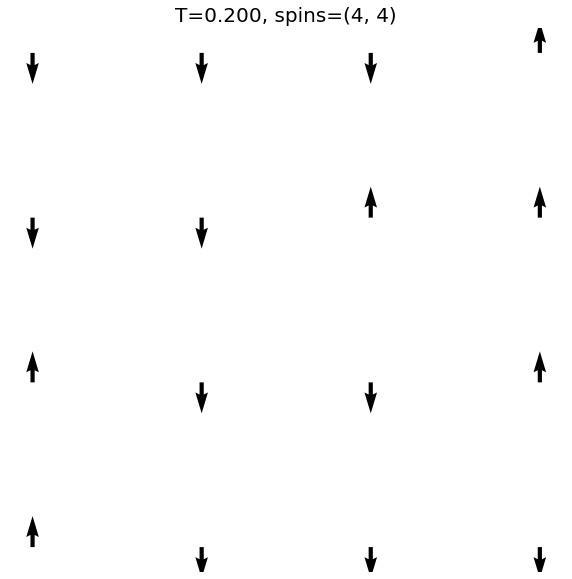

In [48]:
spin_viz(grid_1)

In [49]:
### Burning-in stage
time_start = time.time()
num_steps = 1000
_, _, m_history_1, m_history_2, energy_history_1, energy_history_2, q_list = one_forth_evv(grid_1, grid_2, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 20.56153106689453.


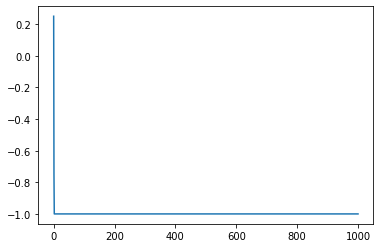

In [50]:
plt.plot(energy_history_1)

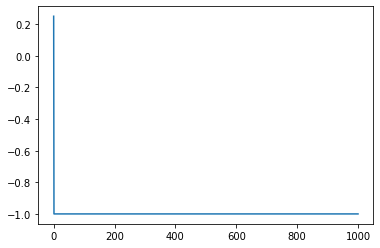

In [51]:
plt.plot(energy_history_2)

In [52]:
m_abs_mean = (np.mean(np.abs(m_history_1)) + np.mean(np.abs(m_history_2))) / 2

In [53]:
print(f"abs mean of m is: {m_abs_mean:.3f}.")

abs mean of m is: 0.436.


-----
### Beta = 5, Size = 8

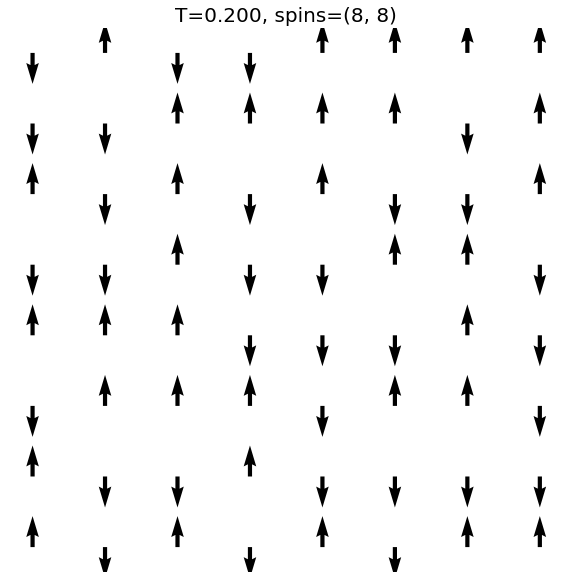

In [51]:
spin_viz(grid_2)

In [52]:
### Burning-in stage
time_start = time.time()
num_steps = 1000
_, _, m_history_1, m_history_2, energy_history_1, energy_history_2, q_list = one_forth_evv(grid_1, grid_2, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_389241/4017202548.py:9: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1980.)
  Q, R = torch.qr(mps[i].contiguous().view(mps[i].shape[0]*2, -1))


Time used for 1E5 steps is: 130.91847944259644.


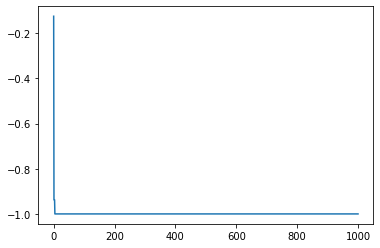

In [53]:
plt.plot(energy_history_1)

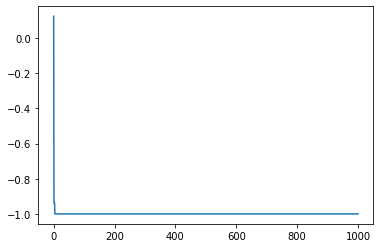

In [54]:
plt.plot(energy_history_2)

In [55]:
m_abs_mean = (np.mean(np.abs(m_history_1)) + np.mean(np.abs(m_history_2))) / 2

In [63]:
print(f"abs mean of m is: {m_abs_mean:.3f}.")

abs mean of m is: 0.401.


-----------------
### Beta = 5, Size = 16

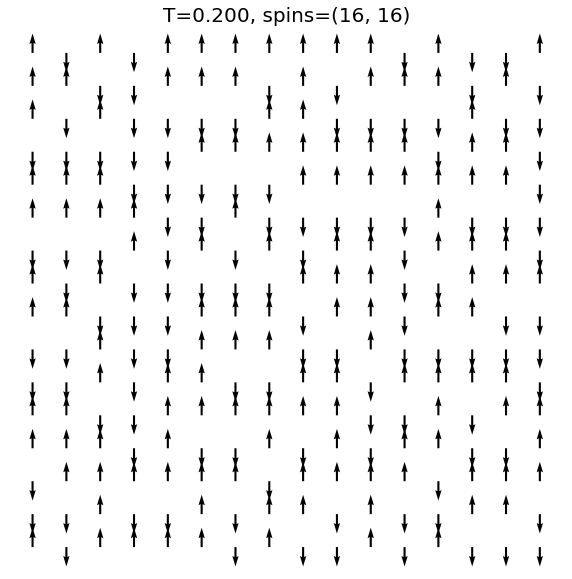

In [48]:
spin_viz(grid_1)

In [49]:
### Burning-in Stage
time_start = time.time()
num_steps, bond_dims = 1000, 20
_, _, m_history_1, m_history_2, energy_history_1, energy_history_2, q_list = one_forth_evv(grid_1, grid_2, num_steps)
time_end = time.time()

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_383881/721598874.py:9: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1980.)
  Q, R = torch.qr(mps[i].contiguous().view(mps[i].shape[0]*2, -1))


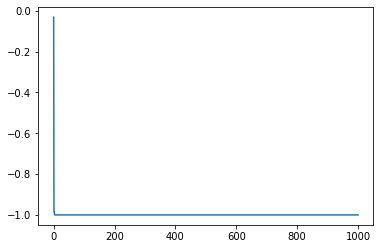

In [57]:
plt.plot(energy_history_1)

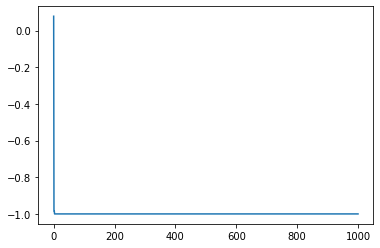

In [59]:
plt.plot(energy_history_2)

In [55]:
m_abs_mean = (np.mean(np.abs(m_history_1)) + np.mean(np.abs(m_history_2))) / 2

In [56]:
print(f"abs mean of m is: {m_abs_mean:.3f}.")

abs mean of m is: 0.349.


-----------------
### Beta = 5, Size = 32

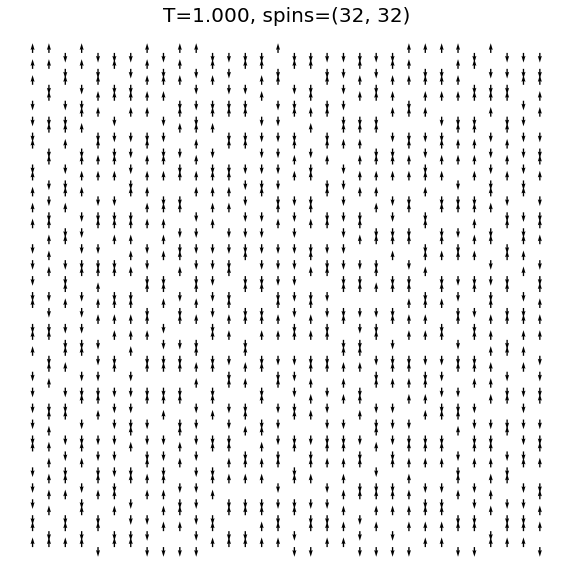

In [45]:
spin_viz(grid_1)

In [ ]:
### Burning-in stage
time_start = time.time()
num_steps, bond_dims = 1000, 50
_, _, m_history_1, m_history_2, energy_history_1, energy_history_2, q_list = one_forth_evv(grid_1, grid_2, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

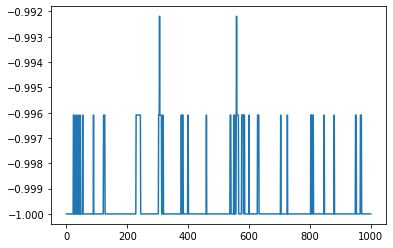

In [67]:
plt.plot(energy_history_1)

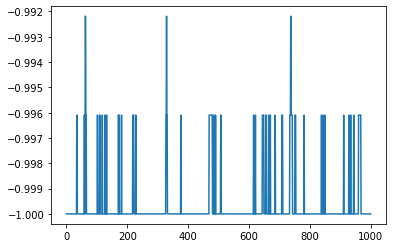

In [68]:
plt.plot(energy_history_2)

<AxesSubplot:ylabel='Count'>

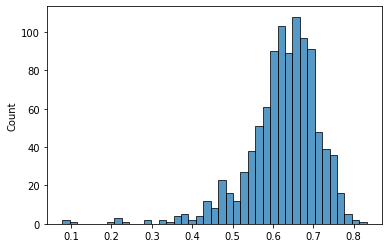

In [69]:
sns.histplot(m_history_1)

<AxesSubplot:ylabel='Count'>

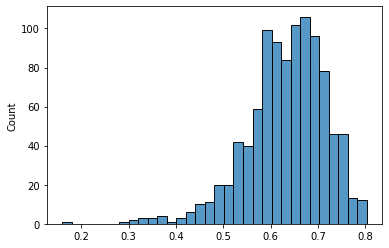

In [70]:
sns.histplot(m_history_2)

In [71]:
m_abs_mean = (np.mean(np.abs(m_history_1)) + np.mean(np.abs(m_history_2))) / 2

In [72]:
print(f"abs mean of m is: {m_abs_mean:.3f}.")

abs mean of m is: 0.628.


<AxesSubplot:ylabel='Count'>

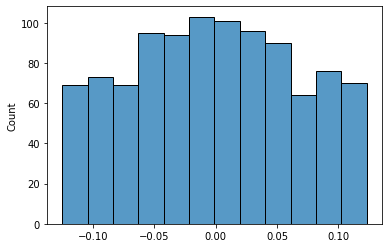

In [65]:
sns.histplot(q_list)

In [60]:
import pickle

In [61]:
with open('../data_2d_ea/ea_square_size_32/ea_square_size_32_beta_5.000_h_0.000_1E3_m_frust_tensor_torch.pkl', 'rb') as file:
    data_dict = pickle.load(file)

In [67]:
data_dict.keys()

dict_keys(['q_list', 'e_mean', 'm_list'])

In [68]:
e_list = data_dict['e_mean']

In [72]:
e_list

[-0.99973828125, -0.99970703125]

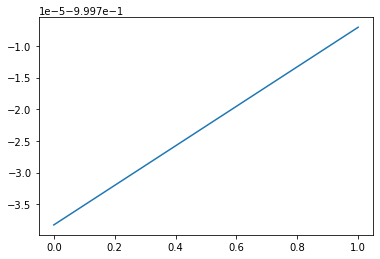

In [71]:
plt.plot(e_list)

In [62]:
m_list = data_dict['m_list']

In [65]:
q_list = data_dict['q_list']

<AxesSubplot:ylabel='Count'>

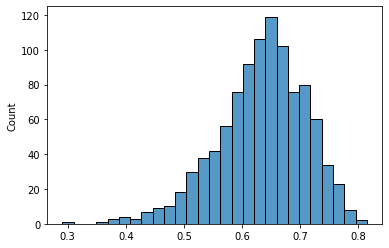

In [64]:
sns.histplot(m_list[0])

<AxesSubplot:ylabel='Count'>

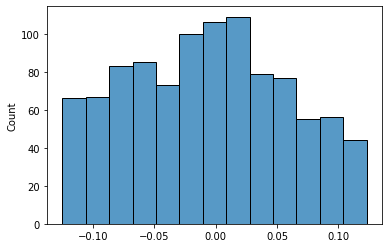

In [66]:
sns.histplot(q_list)

-----------------------